### 데이터 빠른 살펴보기:
Cookie Cats는 Tactile Entertainment에서 개발한 매우 인기 있는 모바일 퍼즐 게임입니다. 이는 클래식한 "세 개 연결" 스타일의 퍼즐 게임으로, 플레이어는 같은 색상의 타일을 연결해 보드를 지워야하며 레벨을 이기게 됩니다. 플레이어들이 게임을 진행하면서 게이트를 만나게 되는데, 이 때 플레이어는 게임을 계속 진행하기 위해 일정 시간 동안 기다리거나 인앱 결제를 해야 합니다.



### 데이터 탐구:

- userid: 각 플레이어를 식별하는 고유 번호입니다.
- version: 플레이어가 gate_30(A) 또는 gate_40(B) 중 어디에 배정되었는지를 나타냅니다.
- sum_gamerounds: 플레이어가 설치 후 첫 주 동안에 플레이한 게임 라운드의 횟수입니다.
- retention_1: 플레이어가 설치한 후 1일 동안 게임을 다시 플레이했는지 여부입니다.
- retention_7: 플레이어가 설치한 후 7일 동안 게임을 다시 플레이했는지 여부입니다.


플레이어가 게임을 설치하면, 그들은 무작위로 gate_30 또는 gate_40 중 하나에 배정되었습니다. 이 프로젝트에서는 Cookie Cats의 첫 번째 게이트가 레벨 30에서 레벨 40으로 옮겨진 것에 대한 A/B 테스트 결과를 분석하게 됩니다.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
df = pd.read_csv("cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [31]:
#I write a function to summarize the general information about the dataset.
def check_df(dataframe, head=10):
    print('\033[1m' + 10*"*" + ' SHAPE ' + 10*"*" + '\033[0m')
    print(f"Rows:{dataframe.shape[0]}")
    print(f"Columns:{dataframe.shape[1]}")

    print('\033[1m' + 10*"*" + ' TYPES ' + 10*"*" + '\033[0m')
    print(dataframe.dtypes)

    print('\033[1m' + 10*"*" + ' HEAD ' + 10*"*" + '\033[0m')
    print(dataframe.head(head))

    print('\033[1m' + 10*"*" + ' TAIL ' + 10*"*" + '\033[0m')
    print(dataframe.tail(head))

    print('\033[1m' + 10*"*" + ' COLUMNS ' + 10*"*" + '\033[0m')
    print(dataframe.columns)

    print('\033[1m' + 10*"*" + ' NUNIQUE ELEMENTS ' + 10*"*" + '\033[0m')
    print(dataframe.nunique())
    print('\033[1m' + 10*"*" + ' NA ' + 10*"*" + '\033[0m')
    print(dataframe.isnull().sum())

    print('\033[1m' + 10*"*" + ' DESCRIBE ' + 10*"*" + '\033[0m')
    print(dataframe.describe().T)
    
check_df(df,10)

********** SHAPE **********
Rows:90189
Columns:5
********** TYPES **********
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
********** HEAD **********
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
6    1066  gate_30               0        False        False
7    1444  gate_40               2        False        False
8    1574  gate_40             108         True         True
9    1587  gate_40             153         True        False
********** TAIL **********
        userid  version  sum_gamerounds  retention_1  reten

<AxesSubplot:xlabel='version', ylabel='count'>

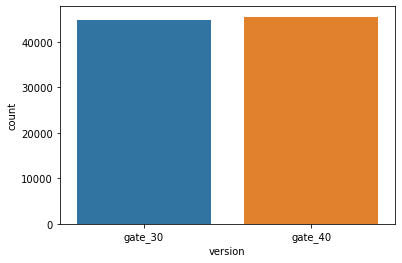

In [32]:
#Let's see the graph for better understanding.
df.groupby("version")["userid"].count()
sns.countplot(x="version",data=df)

In [33]:
df.groupby('version').agg({"sum_gamerounds": ["count", "mean"]}).reset_index()

version sum_gamerounds           
                    count       mean
0  gate_30          44700  52.456264
1  gate_40          45489  51.298776

Text(0, 0.5, 'Mean of gamerounds')

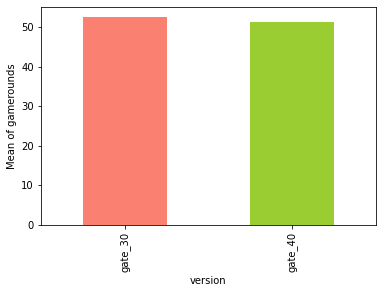

In [34]:
df.groupby("version")["sum_gamerounds"].mean()
df.groupby("version")["sum_gamerounds"].mean().plot(kind="bar", color=[ "salmon", "yellowgreen"])

plt.ylabel("Mean of gamerounds")

### Outliers 
데이터셋에 이상치(아웃라이어) 값이 있을 경우, 그 값은 통계 계산에 영향을 주기 때문에 일반적으로 이러한 값을 제거하는 것이 옳다.

In [35]:
#Before the outlier value
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

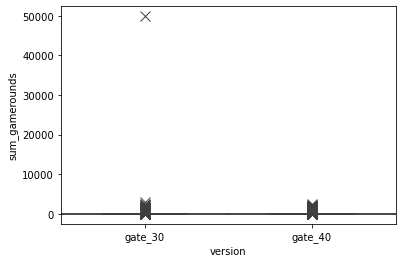

In [36]:
#There is a outlier value in "gate_30".
sns.boxplot(data=df, x="version", y="sum_gamerounds", flierprops={"marker": "x"}, width=1.0, fliersize=10)

In [37]:
# I write a function to get rid of the outlier values.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [43]:
replace_with_thresholds(df, "sum_gamerounds")

In [44]:
#After  removing the outlier value
df.sum_gamerounds.describe()

count    90189.000000
mean        51.109221
std         99.312282
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       1232.500000
Name: sum_gamerounds, dtype: float64

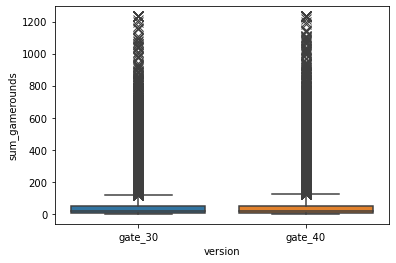

In [45]:
#I saw more logical graph.
sns.boxplot(data=df, x="version", y="sum_gamerounds", flierprops={"marker": "x"}, width=0.8, fliersize=10, showfliers=False);

### A/B 테스팅

#### 1. 가설 설정

- H0: M1 = M2 
- H1: M1 != M2

이 경우에는,

H0: M1 = M2 --- gate_30과 gate_40 사이에 통계적인 차이가 없다.

H1: M1 != M2 --- gate_30과 gate_40 사이에 통계적인 차이가 있다.


#### 2. 가정 검증

- 정규성을 검정하기 전에 이상치 분석 및 보정을 수행하는 것이 도움이 될 수 있다.
- 정규성 가정 (Shapiro Test)
    - H0 : 분포는 정규분포이다.
    - H1 : 분포는 정규분포가 아니다.
- p-value 확인
    - p-value < 0.05 : H0 기각
    - p-value > 0.05 : H1 기각할 수 없음
- 분산의 동질성 (Levene Test)
    - H0 : 분산은 동질하다.
    - H1 : 분산은 동질하지 않다.

#### 3. 가설의 구현
- 분포가 정규분포이며 분산이 동질할 경우: T-검정 (모수 검정) 적용
- 분포가 정규분포이나 분산이 동질하지 않은 경우: Welch 검정 적용
- 분포가 정규분포가 아닌 경우: Mann Whitney U 검정 바로 적용 (비모수 검정)


#### 4. p-value를 기반으로 결과 해석 및 가설 평가

- p-value < 0.05 : H0 기각
- p-value > 0.05 : H1 기각할 수 없음


#### Shapiro-Wilk Test

**Shapiro-Wilk Test (샤피로-윌크 검정)**는 주어진 데이터 집합이 얼마나 잘 정규 분포를 따르는지를 확인하는 통계적 방법입니다. 이 검정은 특히 작은 표본 크기의 데이터셋에서 높은 검정력을 보이며, 데이터의 정규성을 평가하는데 많이 사용됩니다.

Shapiro-Wilk 검정의 귀무 가설과 대립 가설은 다음과 같습니다:

- H0 : 데이터는 정규 분포를 따른다.
- H1 : 데이터는 정규 분포를 따르지 않는다.

검정의 결과로 나온 p-value 값을 기반으로 귀무 가설을 기각할지 결정합니다:

- p-value < 0.05: 대부분의 경우에, 귀무 가설을 기각하게 되며, 이는 데이터가 정규 분포를 따르지 않는다는 것을 나타냅니다.
- p-value ≥ 0.05: 귀무 가설을 기각할 충분한 증거가 없으므로, 데이터가 정규 분포를 따를 수 있다고 판단합니다.

#### Levene 검정
Levene 검정은 두 개 이상의 그룹 간의 분산 동질성을 검정하기 위해 사용되는 통계적 방법입니다. 분산의 동질성은 많은 통계적 방법들, 특히 ANOVA(분산 분석)나 t-검정과 같은 모수적 방법을 적용할 때 중요한 가정 중 하나입니다.

Levene 검정의 귀무 가설과 대립 가설은 다음과 같습니다:

- H0 : 모든 그룹의 분산은 동일하다 (분산 동질성이 있다).
- H1 : 적어도 한 그룹의 분산이 다른 그룹과 다르다 (분산 동질성이 없다).

검정의 결과로 나온 p-value 값을 기반으로 귀무 가설을 기각할지 결정합니다:

- p-value < 0.05: 대부분의 경우에, 귀무 가설을 기각하게 되며, 이는 그룹 간에 분산 동질성이 없다는 것을 나타냅니다.
- p-value ≥ 0.05: 귀무 가설을 기각할 충분한 증거가 없으므로, 그룹 간에 분산이 동질하다고 판단합니다.

Levene 검정은 특히 그룹 간의 분산 차이가 크지 않을 때도 높은 검정력을 보이는 특징이 있습니다.
다만, Levene 검정 외에도 Bartlett 검정과 같은 다른 분산 동질성 검정 방법들도 있으므로, 분석의 목적과 데이터의 특성에 따라 적절한 검정 방법을 선택하는 것이 중요합니다.

In [49]:
def AB_Test(df, pthres=0.05):
    
    # H0:  There is no statistical difference between the gate_30 and the gate_40.
    
    print(df.groupby('version').agg({"sum_gamerounds": ["count", "mean"]}))

    print("NORMAL DISTRIBUTION ASSUMPTION" .center(70,"*"))
    
    # H0 : The compared groups have a normal distribution
    
    pvalue_gate_30 = shapiro([df["version"] == "gate_30"])[1]
    pvalue_gate_40 = shapiro([df["version"] == "gate_40"])[1]
    
    print('p-value_gate30 = %.5f' % (pvalue_gate_30))
    print('p-value_gate40 = %.5f' % (pvalue_gate_40))

    if (pvalue_gate_30 < pthres) & (pvalue_gate_40 < pthres):
        print("Normality H0 is rejected.\n\n")
    else:
        print("Normality H0 is not rejected.\n")

    print("VARIANCE HOMOGENEOUS ASSUMPTION ".center(70,"*"))
    
    # H0 : The variance of compared groups is homegenous.
    
    p_value_levene = levene(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                            df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]
    
    print('p_value_levene = %.5f' % p_value_levene)

    if p_value_levene < pthres:
        print("Variance Homogeneity H0 is rejected.\n")
    else:
        print("Variance Homogeneity H0 is not rejected.\n")

    if ((pvalue_gate_30 > pthres) & (pvalue_gate_40 > pthres)) & (p_value_levene > pthres):
        p_value_ttest = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=True)[1]
        
        print('p_value_ttest = %.5f' % p_value_ttest)

    elif ((pvalue_gate_30 > pthres) & (pvalue_gate_40 > pthres)) & (p_value_levene < pthres):
        p_value_ttest = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=False)[1]
        
        print('p_value_ttest = %.5f' % p_value_ttest)
    else:
        print("Non-Parametric test should be done.\n\n")
        pvalue = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                              df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]
        
        print('p_value = %.5f' % pvalue)

    print(" RESULT ".center(70,"*"))

    if pvalue < pthres:
        print(
            f"p-value {round(pvalue, 5)} < 0.05  H0 Hypothesis is Rejected. That is, there is a statistically significant difference between them.")

    else:
        print(
            f"p-value > {pthres} H0 is Not Rejected, That is, there is no statistically significant difference between them. The difference was made by chance.")

AB_Test(df,0.05)

        sum_gamerounds           
                 count       mean
version                          
gate_30          44700  51.153423
gate_40          45489  51.065785
********************NORMAL DISTRIBUTION ASSUMPTION********************
p-value_gate30 = 0.00000
p-value_gate40 = 0.00000
Normality H0 is rejected.


*******************VARIANCE HOMOGENEOUS ASSUMPTION *******************
p_value_levene = 0.83018
Variance Homogeneity H0 is not rejected.

Non-Parametric test should be done.


p_value = 0.05021
******************************* RESULT *******************************
p-value > 0.05 H0 is Not Rejected, That is, there is no statistically significant difference between them. The difference was made by chance.
